In [1]:
import networkx
import matplotlib.pyplot as plt
import numpy as np
import os
import torch_geometric as pyg
import matplotlib
import scipy.spatial
import sys

from torch_geometric.utils.convert import from_networkx

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
src_path = os.path.join(project_root, "src")
sea_cast_tools_path = os.path.join(src_path, "seacast_tools")
if src_path not in sys.path:
    sys.path.insert(0, src_path)
if sea_cast_tools_path not in sys.path:
    sys.path.insert(0, sea_cast_tools_path)

import src.seacast_tools.mesh_models.mesh_connector as mc
import src.seacast_tools.mesh_models.mesh_metrics as mm
from src.seacast_tools.mesh_models.Non_uniform_mesh import NonUniformMesh

In [2]:

class UniformMesh(NonUniformMesh):
    """
    Uniform mesh class for generating a 2D non-uniform graph using networkx.
    Inherits from NonUniformMesh class.
    """

    def __init__(self, xy, nx, land_mask, graph_type, root_path_to_save, supplementary_masks):
        super().__init__(xy, nx, land_mask, graph_type, root_path_to_save, supplementary_masks)

    def mk_2d_non_uniform_graph(self, n_nodes_x, n_nodes_y, *args, **kwargs):
        xm, xM = np.amin(self.xy[0][0, :]), np.amax(self.xy[0][0, :])
        ym, yM = np.amin(self.xy[1][:, 0]), np.amax(self.xy[1][:, 0])

        # avoid nodes on border
        dx = (xM - xm) / n_nodes_x
        dy = (yM - ym) / n_nodes_y
        lx = np.linspace(xm + dx / 2, xM - dx / 2, n_nodes_x, dtype=np.float32)
        ly = np.linspace(ym + dy / 2, yM - dy / 2, n_nodes_y, dtype=np.float32)
        # for plotting purposes
        X, Y = np.meshgrid(lx, ly)                  # both shape (n_nodes_y, n_nodes_x)
        coords = np.column_stack((X.ravel(), Y.ravel()))
        counts = mm.count_nodes_in_masks(self.supplementary_masks, coords)
        title = f"total nodes for each mask in level {n_nodes_x}.svg"
        filepath = os.path.join(self.path_to_save_figures, self.graph_type, title)
        mm.plot_counts_table(counts, title, filepath)
        
        mg = np.meshgrid(lx, ly)
        g = networkx.grid_2d_graph(len(ly), len(lx))

        # kdtree for nearest neighbor search of land nodes
        land_points = np.argwhere(self.land_mask.T).astype(np.float32)
        land_kdtree = scipy.spatial.KDTree(land_points)

        # add nodes excluding land
        for node in list(g.nodes):
            node_pos = np.array([mg[0][node], mg[1][node]], dtype=np.float32)
            dist, _ = land_kdtree.query(node_pos, k=1)
            if dist < np.sqrt(0.5):
                g.remove_node(node)
            else:
                g.nodes[node]["pos"] = node_pos

        # add diagonal edges if both nodes exist
        #for x in range(n_nodes_x - 1):
        #    for y in range(n_nodes_y - 1):
        #        if g.has_node((x, y)) and g.has_node((x + 1, y + 1)):
        #            g.add_edge((x, y), (x + 1, y + 1))
        #        if g.has_node((x + 1, y)) and g.has_node((x, y + 1)):
        #            g.add_edge((x + 1, y), (x, y + 1))
        mc.add_Delaunay_edges(g)

        # remove edges that goes across land
        for u, v in list(g.edges()):
            if mc.crosses_land(g.nodes[u]["pos"], g.nodes[v]["pos"], self.land_mask):
                g.remove_edge(u, v)

        # turn into directed graph
        dg = networkx.DiGraph(g)

        # add node data
        for u, v in g.edges():
            d = np.sqrt(np.sum((g.nodes[u]["pos"] - g.nodes[v]["pos"]) ** 2))
            dg.edges[u, v]["len"] = d
            dg.edges[u, v]["vdiff"] = g.nodes[u]["pos"] - g.nodes[v]["pos"]
            dg.add_edge(v, u)
            dg.edges[v, u]["len"] = d
            dg.edges[v, u]["vdiff"] = g.nodes[v]["pos"] - g.nodes[u]["pos"]

        # add self edge if needed
        for v, degree in list(dg.degree()):
            if degree <= 1:
                dg.add_edge(v, v, len=0, vdiff=np.array([0, 0]))

        return dg

    def create_mesh_levels(self, n_levels, plot, resolutions_list, *args, **kwargs):
        if len(resolutions_list) != n_levels:
            raise ValueError("Number of levels and number of resolutions must be equal")
        G_list = []
        for lev in range(1, n_levels + 1):
            n = resolutions_list[lev - 1]
            print(f"level {lev}, n: {n}")
            g = self.mk_2d_non_uniform_graph(n, n, *args, **kwargs)
            if plot == True:
                mm.plot_graph(
                    from_networkx(g),
                    title=f"Mesh graph, level {lev}",
                    graph_type=self.graph_type,
                    save_dir=self.path_to_save_figures
                )
                g_metrics = mm.metrics_from_networkx_graph(g, None)
                mm.plot_degree_distribution(
                    g_metrics["count_degrees"], title=f"Mesh graph level {lev} nodes degree",
                    graph_type=self.graph_type, save_dir=self.path_to_save_figures)
                mm.create_metrics_table(
                    g_metrics, None,
                    columns_names=["nodes"],
                    metrics_to_avoid=["count_degrees"],
                    title=f"Mesh graph level {lev} metrics", graph_type=self.graph_type,
                    save_dir=self.path_to_save_figures
                    )
            G_list.append(g)
        return G_list

    def add_down_edges(self, G_down, v_to_list, v_from_list, kdt_m, k_neighboors,*args, **kwargs):
        mc.add_edges_based_in_k_neighboors(G_down, v_from_list, v_to_list, kdt_m, self.land_mask, k_neighboors=k_neighboors)

    def establish_edges_g2m(self, graph, sender_nodes_list, receiver_nodes_list, required_connections,*args, **kwargs):
        receiver_nodes_list = [node for node in receiver_nodes_list if node[0] == 0]
        mc.establish_n_edges_g2m(graph, sender_nodes_list, receiver_nodes_list, required_connections=required_connections)

    def establish_edges_m2g(self, graph, *args, **kwargs):
        G_m2g = mc.create_reversed_graph(graph)
        return G_m2g

In [3]:
def load_supplementary_masks(supplementary_dir):
    masks = {}
    for file in os.listdir(supplementary_dir):
        if file.endswith(".npy"):
            mask_name = file.split(".")[0]
            masks[mask_name] = np.load(os.path.join(supplementary_dir, file))
            print(f"Loaded mask: {mask_name}")
    return masks

def calculate_mesh_levels(levels_proposed, xy, nx):
    nlev = int(np.log(max(xy.shape)) / np.log(nx))
    mesh_levels = nlev -1
    if levels_proposed is not None:
        mesh_levels = min(mesh_levels, levels_proposed)
    return mesh_levels

python .\create_non_uniform_mesh.py --dataset atlantic --plot 1 --mesh_type random

In [4]:
dataset = "atlantic"
mesh_type = "uniform"
graph_type = "hierarchical"
levels_proposed = 3
plot = 1

In [5]:
root_dir = project_root
static_dir_path = os.path.join(root_dir, "data", dataset, "static")
original_graphs_dir_path = os.path.join(root_dir, "graphs", graph_type)
xy = np.load(os.path.join(static_dir_path, "nwp_xy.npy"))
sea_mask = np.load(os.path.join(static_dir_path, "sea_mask.npy"))
#load supplementary masks
supplementary_dir = os.path.join(sea_cast_tools_path,"mesh_models", "supplementary_masks")
if os.path.exists(supplementary_dir):
    supplementary_masks = load_supplementary_masks(supplementary_dir)
else:
    assert False, "No supplementary masks found. Please check the path."
land_mask = ~sea_mask[0]

Loaded mask: upwelling_zone
Loaded mask: white_cape_mask
Loaded mask: almost_top_cape_mask
Loaded mask: middle_coast_mask
Loaded mask: non_upwelling_ocean


In [6]:
current_experiment = "non_crossing_edges"
resolutions_list = [27, 9, 3]
#resolutions_list = [18, 6, 3]
resolutions_list_string_for_path = "_".join([str(res) for res in resolutions_list])
print(f"resolutions_list_string_for_path: {resolutions_list_string_for_path}")
base_dir_path_to_save= os.path.join(root_dir, graph_type, current_experiment, resolutions_list_string_for_path)
if not os.path.exists(base_dir_path_to_save):
    os.makedirs(base_dir_path_to_save)
    os.makedirs(os.path.join(base_dir_path_to_save, "figures",mesh_type, resolutions_list_string_for_path))


resolutions_list_string_for_path: 27_9_3


In [7]:
# final solution to save figures
#save_dir = os.path.join('d:', 'ULPGC', '4Curso', 'TFG', 'seacast_code', 'Proyecto_TFG', 'Seacast', 
#                        'hierarchical', 'non_crossing_edges', 'figures', 'uniform')
#
## Check if the directory exists, and if not, create it
#if not os.path.exists(save_dir):
#    os.makedirs(save_dir)

level 1, n: 27
Figure saved in: d:\ULPGC\4Curso\TFG\seacast_code\Proyecto_TFG\Seacast\hierarchical\non_crossing_edges\27_9_3\figures\uniform\Mesh graph, level 1.svg
level 2, n: 9
Figure saved in: d:\ULPGC\4Curso\TFG\seacast_code\Proyecto_TFG\Seacast\hierarchical\non_crossing_edges\27_9_3\figures\uniform\Mesh graph, level 2.svg
level 3, n: 3
Figure saved in: d:\ULPGC\4Curso\TFG\seacast_code\Proyecto_TFG\Seacast\hierarchical\non_crossing_edges\27_9_3\figures\uniform\Mesh graph, level 3.svg
Figure saved in: d:\ULPGC\4Curso\TFG\seacast_code\Proyecto_TFG\Seacast\hierarchical\non_crossing_edges\27_9_3\figures\mesh_down\uniform\Mesh down 1 to 0 graph.svg
Figure saved in: d:\ULPGC\4Curso\TFG\seacast_code\Proyecto_TFG\Seacast\hierarchical\non_crossing_edges\27_9_3\figures\mesh_up\uniform\Mesh up 0 to 1 graph.svg
Figure saved in: d:\ULPGC\4Curso\TFG\seacast_code\Proyecto_TFG\Seacast\hierarchical\non_crossing_edges\27_9_3\figures\mesh_down\uniform\Mesh down 2 to 1 graph.svg
Figure saved in: d:\UL

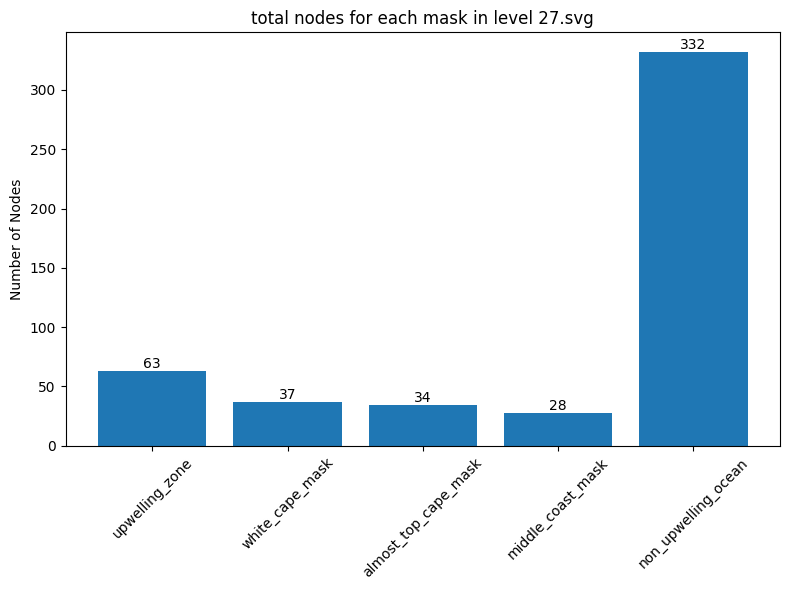

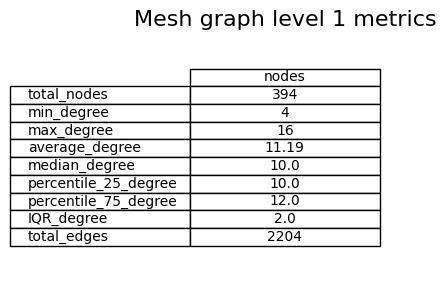

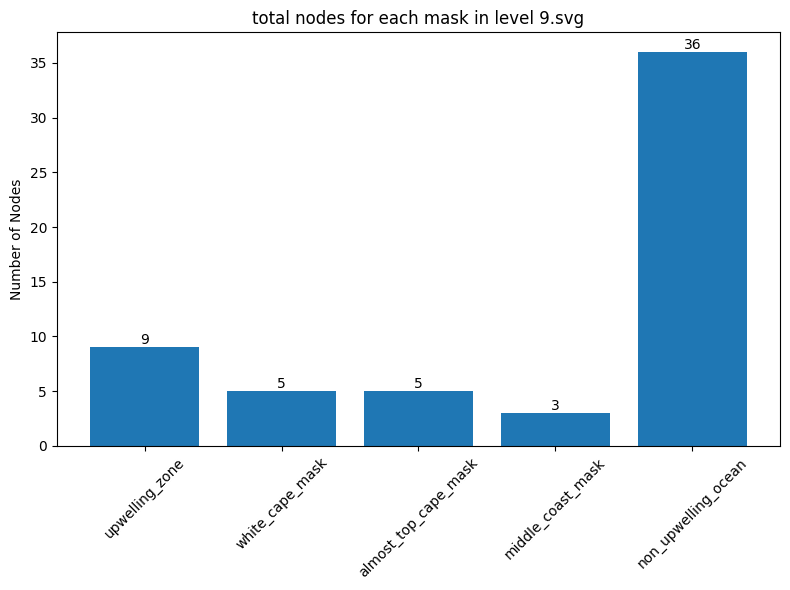

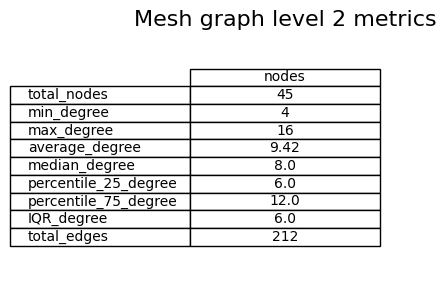

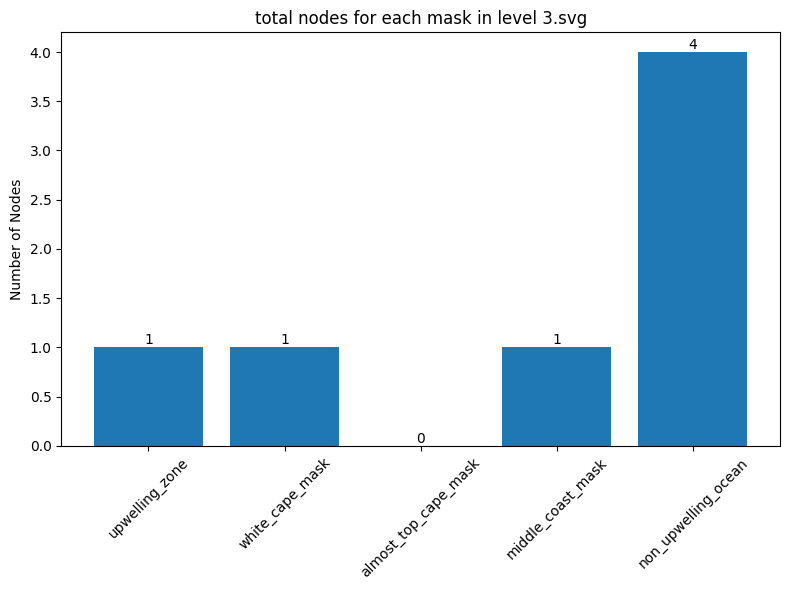

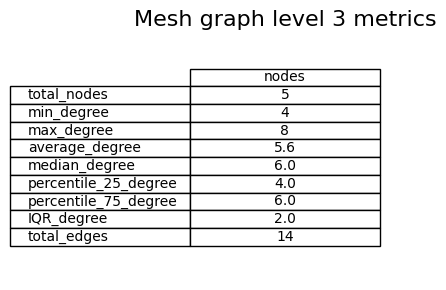

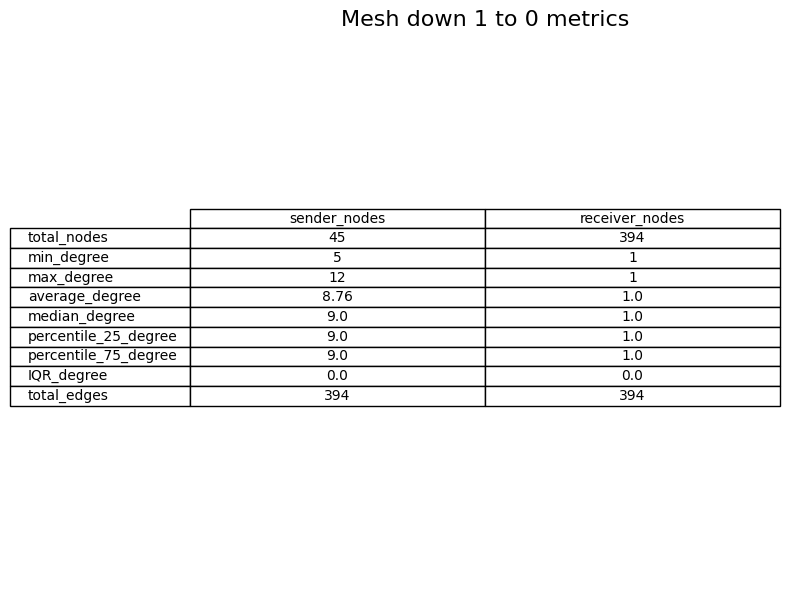

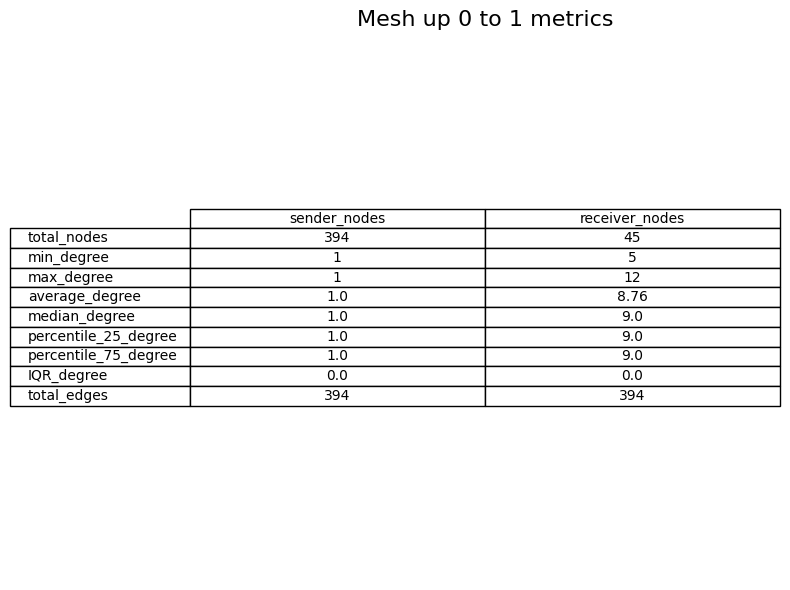

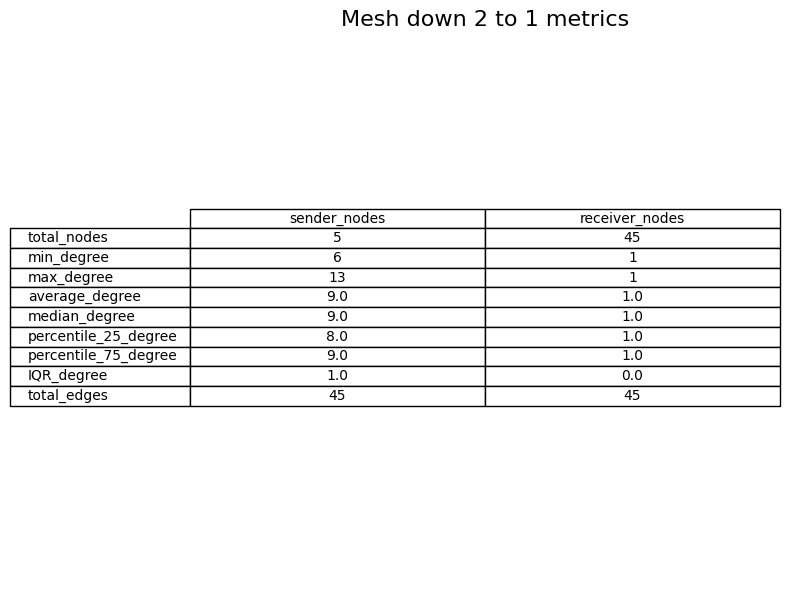

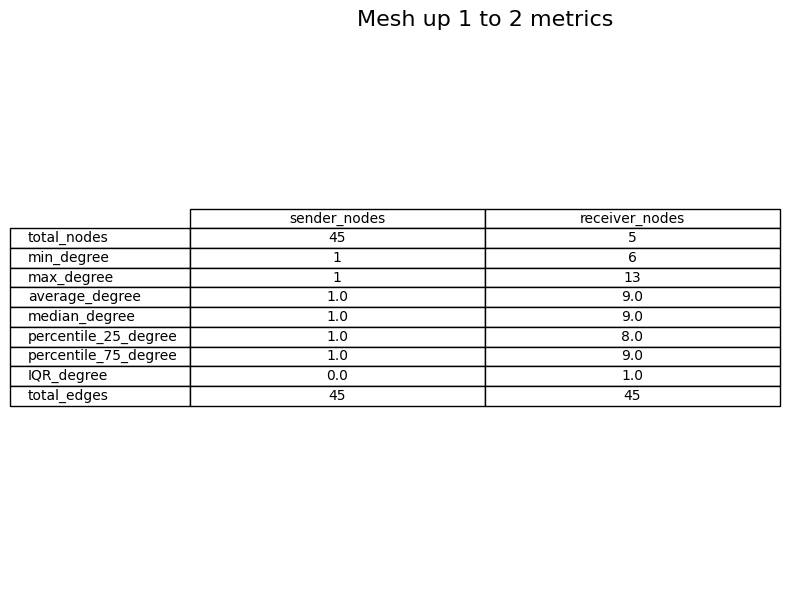

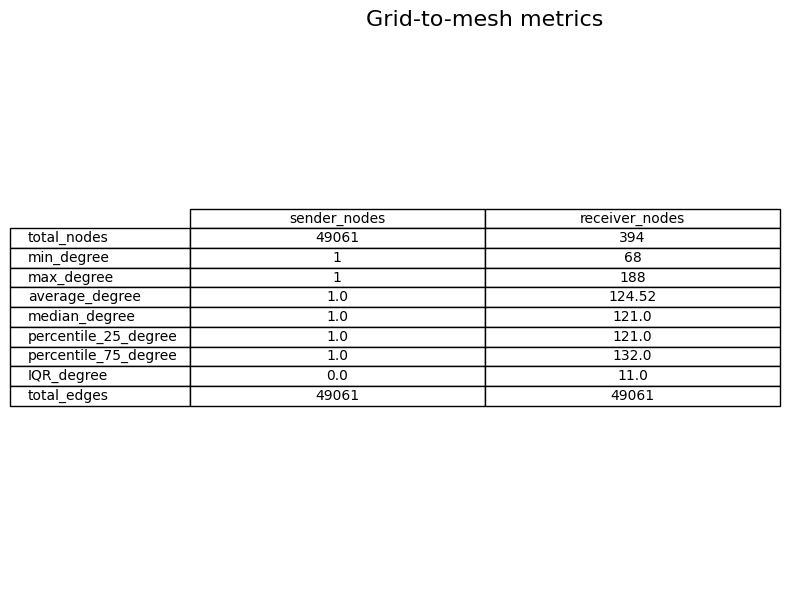

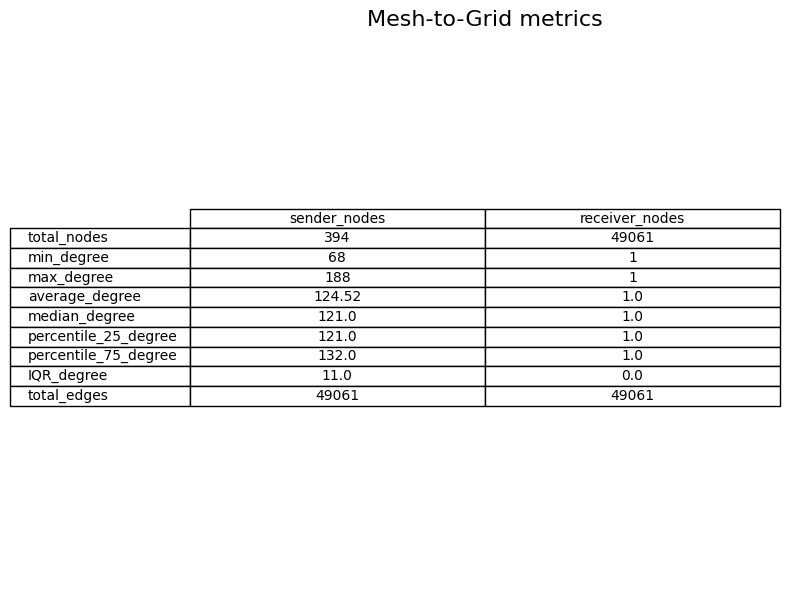

In [ ]:
#for fixed experiments with 3 levels
fixed_total_nodes = True
total_nodes_for_each_level = {81: 3568, 27: 394, 9: 45}

#Use implementation
if mesh_type == "uniform":
        nx = 3
        mesh_levels = calculate_mesh_levels(levels_proposed, xy, nx)
        mesh = UniformMesh(xy, nx, land_mask, mesh_type,
                          base_dir_path_to_save, supplementary_masks=supplementary_masks)
        graph_list = mesh.create_mesh_levels(mesh_levels, plot = bool(plot), resolutions_list=resolutions_list)
        graph_list, first_index_level = mesh.prepare_hierarchical_graphs(graph_list)
        mesh.create_hierarchical_mesh_up_mesh_down_edges(graph_list, mesh_levels, 
                                                        first_index_level, plot = bool(plot),
                                                        k_neighboors = 1, 
                                                        )
        m2m_graphs = mesh.create_hierarchical_m2m_graph(graph_list, first_index_level=first_index_level)
        mesh.create_mesh_features(m2m_graphs)
        G_g2m = mesh.create_g2m_graph(graph_list, plot = bool(plot), required_connections=1)
        mesh.create_m2g_graph(G_g2m, plot= bool(plot))
        